In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
from scipy.stats import norm

np.random.seed(0)

In [ ]:
def get_radar(xpos_pred):
    """Return Predicted Horizontal Distance and Measured Distance by Radar."""
    xvel_w = np.random.normal(0, 5)   # xvel_w: system noise of horizontal velocity [m/s].
    xvel_true = 100 + xvel_w          # xvel_true: true horizontal velocity [m/s].

    ypos_w = np.random.normal(0, 10)  # ypos_w: system noise of vertical position [m].
    ypos_true = 1000 + ypos_w         # ypos_true: true vertical position [m].

    xpos_pred = xpos_pred + xvel_true * dt      # 이동거리               # xpos_pred: predicted horizontal distance [m].

    rpos_v = xpos_pred * np.random.normal(0, 0.05)             # rpos_v: measurment noise of distance from radar.
    rpos_meas = np.sqrt(xpos_pred**2 + ypos_true**2) + rpos_v # 측정한 거리 # r: measured distance [m] (observable).

    return rpos_meas, xpos_pred

In [ ]:
def fx(x_esti):
    return A @ x_esti

def hx(x_pred):
    z_pred = np.sqrt(x_pred[0]**2 + x_pred[2]**2)
    return np.array([z_pred])

In [ ]:
def particle_filter(z_meas, pt, wt):
    """Particle Filter Algorithm.
        - norm.pdf(x, mu, sigma):
            the pdf of the normal distribution with mean mu
            and standard deviation sigma, evaluated at the values x.
    """
    # (1) Predict Particles.
    pt = fx(pt) + np.random.randn(*pt.shape)

    # (2) Update Weights.
    wt = wt*norm.pdf(z_meas, hx(pt), 10)
    wt = wt / np.sum(wt)

    # (3) Estimate States.
    x_esti = pt @ wt.T

    # (4) Resample Particles using Sequential Importance Resampling (SIR).
    Npt = pt.shape[1]
    inds = np.random.choice(Npt, Npt, p=wt[0], replace=True)
    pt = pt[:, inds]
    wt = np.ones((1, Npt)) / Npt  # 가중치 균일하게 초기화

    return x_esti, pt, wt

In [ ]:
# Input parameters.
time_end = 20
dt = 0.05

In [ ]:
# Initialization for system model.
# Matrix: A, H, Q, R, P_0
# Vector: x_0
A = np.eye(3) + dt * np.array([[0, 1, 0],
                               [0, 0, 0],
                               [0, 0, 0]])
# Initialization for estimation.
x_0 = np.array([0, 90, 1100])  # [horizontal position, horizontal velocity, vertical position].

# Initialization for particles.
Npt = 1000

In [ ]:
time = np.arange(0, time_end, dt)
n_samples = len(time)
xpos_esti_save = np.zeros(n_samples)
ypos_esti_save = np.zeros(n_samples)
rpos_esti_save = np.zeros(n_samples)
xvel_esti_save = np.zeros(n_samples)
rpos_meas_save = np.zeros(n_samples)

In [ ]:
xpos_pred = 0
x_esti, pt, wt = None, None, None
for i in range(n_samples):
    z_meas, xpos_pred = get_radar(xpos_pred)
    if i == 0:
        x_esti = x_0
        pt     = x_0.reshape(-1, 1) + 0.1 * x_0.reshape(-1, 1) * np.random.randn(1, Npt)
        wt     = np.ones((1, Npt)) / Npt
    else:
        x_esti, pt, wt = particle_filter(z_meas, pt, wt)
        
    xpos_esti_save[i] = x_esti[0]
    ypos_esti_save[i] = x_esti[2]
    rpos_esti_save[i] = np.sqrt(x_esti[0]**2 + x_esti[2]**2)
    xvel_esti_save[i] = x_esti[1]
    rpos_meas_save[i] = z_meas

Text(0, 0.5, 'Horizontal Velocity [m/s]')

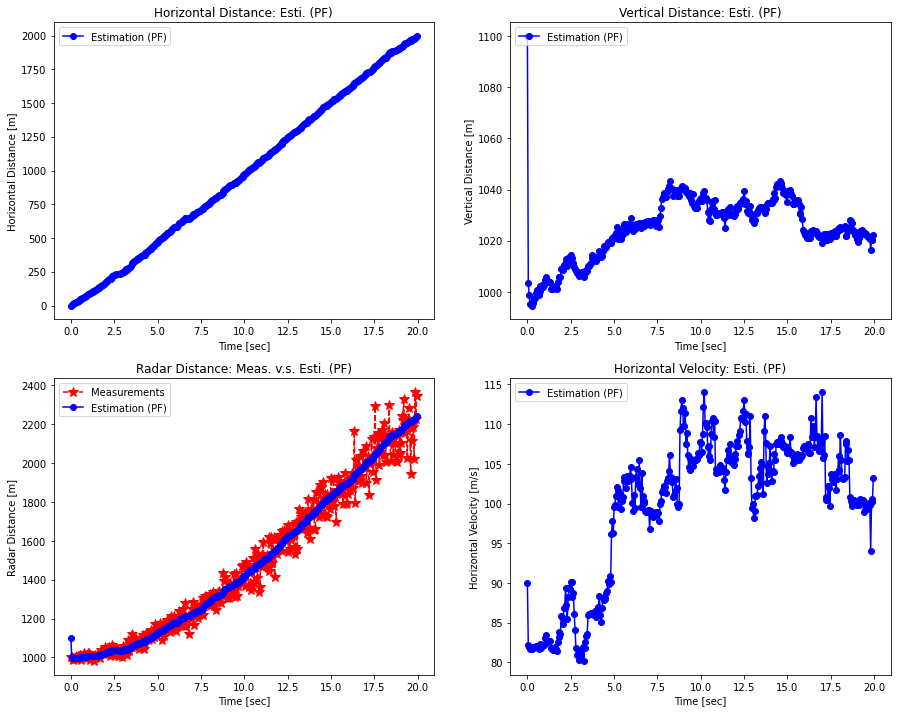

In [ ]:

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))

axes[0, 0].plot(time, xpos_esti_save, 'bo-', label='Estimation (PF)')
axes[0, 0].legend(loc='upper left')
axes[0, 0].set_title('Horizontal Distance: Esti. (PF)')
axes[0, 0].set_xlabel('Time [sec]')
axes[0, 0].set_ylabel('Horizontal Distance [m]')

axes[0, 1].plot(time, ypos_esti_save, 'bo-', label='Estimation (PF)')
axes[0, 1].legend(loc='upper left')
axes[0, 1].set_title('Vertical Distance: Esti. (PF)')
axes[0, 1].set_xlabel('Time [sec]')
axes[0, 1].set_ylabel('Vertical Distance [m]')

axes[1, 0].plot(time, rpos_meas_save, 'r*--', label='Measurements', markersize=10)
axes[1, 0].plot(time, rpos_esti_save, 'bo-', label='Estimation (PF)')
axes[1, 0].legend(loc='upper left')
axes[1, 0].set_title('Radar Distance: Meas. v.s. Esti. (PF)')
axes[1, 0].set_xlabel('Time [sec]')
axes[1, 0].set_ylabel('Radar Distance [m]')

axes[1, 1].plot(time, xvel_esti_save, 'bo-', label='Estimation (PF)')
axes[1, 1].legend(loc='upper left')
axes[1, 1].set_title('Horizontal Velocity: Esti. (PF)')
axes[1, 1].set_xlabel('Time [sec]')
axes[1, 1].set_ylabel('Horizontal Velocity [m/s]')